In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [47]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [48]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [49]:
DIR_DATA  = '../input/diploma/'

In [200]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# Вспомогательные функции расчета метрик.

In [51]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [52]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [53]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

# Общие сведения, задачи, примерный план работы.

In [54]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Задачи на текущем этапе

1. С точки зрения здравого смысле должна быть корреляция между улицей и городом. Возможны проблемы с сочетанием популярности улицы - непопулярности города и наоборот. Что с этим делать пока непонятно.

2. Признак школы объединяет три фрагмента информации: рейтинг школы, удаленность от школы, название школы. С точки зрения здравого смысла, рейтинг и удаленность должны заметно влиять на цену. Проблема с признаком: неряшливая запись, практически невозможно выделить какой-то формат. Пока работаю над ним.

3.  mls_id и MLSID: похоже, одно и то же. Посмотреть распределение значений mls_id, скорее всего, можно будет просто выкинуть. MLSID, наверное, тоже.  # удалено. Скорее всего, на цену не влияет.

4. Признак факты содержит дополнительную информацию. В признаке хорошо выделяется структура: список словарей. Написана функция, выделяющая собственно этот список, в которой проявляется ошибка. Работаю над исправлением.


# Текущая модель

Из предварительной выборки удалены признаки:

private pool

улица

mls_id и MLSID

общий признак школы

общий признак факты

    
# Дальнейшие задачи

1. Обработка признаков школы и факты, добавление новых столбцов в датасет, добавление в модель.

2. Эксперименты с моделями.

3. Провести более точное удаление выбросов целевой переменной, посмотреть результаты.

Удалено, потому что громоздко.

# Анализ целевой переменной.

In [201]:
data_d.head(10)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,"$209,000"
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,NaN,NaN,S5026943,"181,500"
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,"68,000"
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,50401,3,IA,NaN,NaN,NaN,190988,"$244,900"
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,NaN,NaN,73968331,"$311,995"


# Вспомогательная функция извлечения числа из записи доллара.

In [202]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [203]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [204]:
data_d['target'].isna().unique()

array([False,  True])

In [205]:
data_d['target'].value_counts()

225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
325000.0    1562
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34232, dtype: int64

In [206]:
data_d['target'].fillna(value = data_d.target.median(), inplace = True)

# Заполнить недостающие значения после оформления признака площадь.

In [61]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

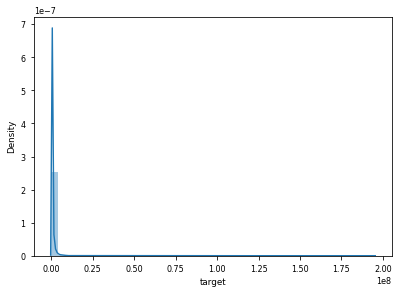

In [207]:
sns.distplot(data_d['target'])

Предварительное грубое удаление выбросов.

In [208]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [209]:
data_d = data_d[(data_d['target'] < 550000)]

<AxesSubplot:xlabel='target', ylabel='Density'>

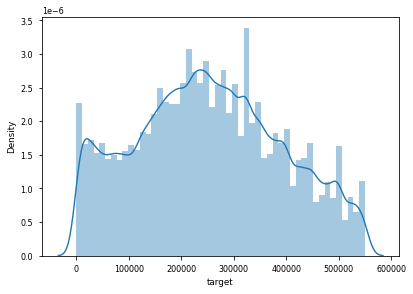

In [210]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f67b19fc310>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f67b1c3d890>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f67b1999810>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f67b1999c50>}

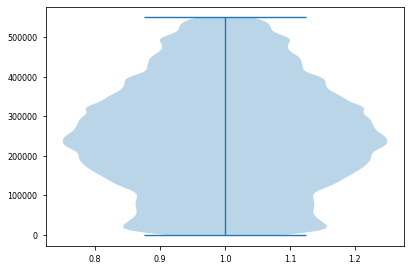

In [66]:
plt.violinplot(data_d['target'])

In [211]:
data_d['target'].isna().unique()

array([False])

In [68]:
data_d.loc[data_d['target']==0]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [69]:
data_d.loc[data_d['target'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                   1,947 sqft
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

In [70]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [71]:
#data_d['target'].isna().unique()

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [212]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [213]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

In [214]:
data_d['sqft'].value_counts()

0.0        10652
1200.0      1232
1000.0       906
1100.0       798
1500.0       769
           ...  
8754.0         1
64.0           1
6223.0         1
46996.0        1
7644.0         1
Name: sqft, Length: 5854, dtype: int64

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [215]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [216]:
data_d['sqft'].value_counts()

1200.0     1232
1000.0      906
1100.0      798
1500.0      769
1400.0      749
           ... 
8754.0        1
64.0          1
6223.0        1
46996.0       1
7644.0        1
Name: sqft, Length: 5853, dtype: int64

In [217]:
data_d['sqft'].unique()

array([2.90000000e+03, 1.94700000e+03,            nan, ...,
       7.20000000e+01, 4.56602479e+08, 7.64400000e+03])

In [218]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276948 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246827 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  253129 non-null  object 
 3   street        276947 non-null  object 
 4   baths         194069 non-null  object 
 5   homeFacts     276948 non-null  object 
 6   fireplace     67586 non-null   object 
 7   city          276928 non-null  object 
 8   schools       276948 non-null  object 
 9   sqft          235646 non-null  float64
 10  zipcode       276948 non-null  object 
 11  beds          207050 non-null  object 
 12  state         276948 non-null  object 
 13  stories       169302 non-null  object 
 14  mls-id        19149 non-null   object 
 15  PrivatePool   22749 non-null   object 
 16  MlsId         224599 non-null  object 
 17  target        276948 non-null  float64
dtypes: f

# Заполнить пропуски по комнатам

In [79]:
data_d.loc[data_d['sqft'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                       1947.0
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

# Спальни - приведение к численному виду.

In [219]:
data_d['beds'].value_counts()

3 Beds        42890
4 Beds        24758
3             24356
2 Beds        20440
4             12920
              ...  
40 acres          1
6.53 acres        1
9,291 sqft        1
6,115 sqft        1
8,479 sqft        1
Name: beds, Length: 959, dtype: int64

In [81]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])

In [82]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"{'atAGlanceFacts': [{'factValue': '1922', 'fac...",NaN,Falconer,"[{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'dat...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,79000.0


Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [220]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [221]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [222]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

1                                                                         157719
3 Beds                                                                     42890
4 Beds                                                                     24758
2 Beds                                                                     20440
3 bd                                                                       11138
4 bd                                                                        6106
5 Beds                                                                      4814
2 bd                                                                        4650
5 bd                                                                        1317
6 Beds                                                                      1142
1 bd                                                                         982
6 bd                                                                         266
7 Beds                      

In [223]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


Вспомогательная функция для выбора числового значения признака спальни.

In [224]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [225]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [226]:
data_d['beds'].unique()                        


array([ 1,  3,  2,  4,  5,  6,  8,  7, 10, 64, 24,  9, 11, 16, 18, 12, 44,
       17, 14, 13, 15, 28, 20])

In [227]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276948 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246827 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  253129 non-null  object 
 3   street        276947 non-null  object 
 4   baths         194069 non-null  object 
 5   homeFacts     276948 non-null  object 
 6   fireplace     67586 non-null   object 
 7   city          276928 non-null  object 
 8   schools       276948 non-null  object 
 9   sqft          235646 non-null  float64
 10  zipcode       276948 non-null  object 
 11  beds          276948 non-null  int64  
 12  state         276948 non-null  object 
 13  stories       169302 non-null  object 
 14  mls-id        19149 non-null   object 
 15  PrivatePool   22749 non-null   object 
 16  MlsId         224599 non-null  object 
 17  target        276948 non-null  float64
dtypes: f

# Визуализация и обработка признака спальни (beds).

<AxesSubplot:xlabel='beds', ylabel='Density'>

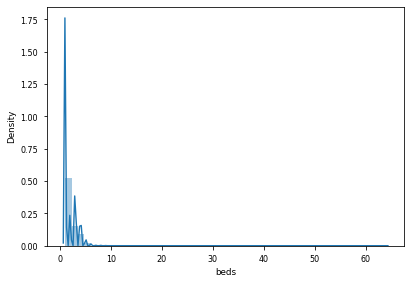

In [91]:
sns.distplot(data_d['beds'])

In [228]:
data_d = data_d[(data_d['sqft'] < 10)]

<AxesSubplot:xlabel='beds', ylabel='Density'>

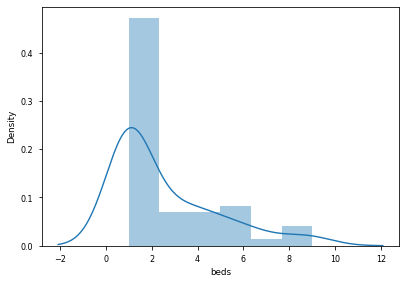

In [229]:
sns.distplot(data_d['beds'])

# Возвращаемся к площади и заполняем пропуски по среднему для группы по комнатам.

In [230]:
data_d['sqft'].fillna(data_d.groupby('beds')['sqft'].transform('mean'), inplace = True)

In [231]:
data_d.head(30)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
564,NaN,NaN,Single Family,524 SW 24th Ave,1,"{'atAGlanceFacts': [{'factValue': '1954', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['4/10', '4/10', '3/10'], 'data': ...",1.0,33312,1,FL,1.0,NaN,NaN,NaN,197717.0
3763,New construction,NaN,Single Family,99 W 5th St,Bathrooms: 3,"{'atAGlanceFacts': [{'factValue': '1949', 'fac...",Yes,Pottstown,"[{'rating': ['3/10', '3/10', '3/10'], 'data': ...",1.0,19464,4,PA,2.0,PAMC626746,NaN,NaN,217700.0
5881,for sale,NaN,mobile/manufactured,15777 Bolesta Rd #34,2 Baths,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,Clearwater,"[{'rating': ['4/10', '3/10', '8/10'], 'data': ...",6.0,33760,2,FL,NaN,NaN,NaN,10654105,31900.0
18537,for sale,NaN,multi-family,3138 W Wabansia Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1892', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '2/10'], 'data': {'Distan...",1.0,60647,4,IL,NaN,NaN,NaN,10579841,480000.0
25078,for sale,NaN,lot/land,3 Berryville St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,El Paso,"[{'rating': ['9/10', '8/10', '4/10'], 'data': ...",1.0,79928,1,TX,NaN,NaN,NaN,806091,64000.0
29107,for sale,NaN,lot/land,4240 N Melvina Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '7/10', '8/10'], 'data': ...",1.0,60634,3,IL,NaN,NaN,NaN,10556171,245000.0
32262,For sale,NaN,Single Family,241 High Rd NW,2 ba,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Palm Bay,"[{'rating': ['3/10', '6/10', '4/10'], 'data': ...",1.0,32907,3,FL,NaN,852525,NaN,NaN,185900.0
33732,for sale,NaN,multi-family,1310 W 71st Pl,NaN,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",yes,Chicago,"[{'rating': ['2/10', '4/10', '1/10'], 'data': ...",1.0,60636,4,IL,NaN,NaN,NaN,10549506,144900.0
40392,for sale,NaN,lot/land,5415 Tanner Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1901', 'fac...",NaN,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '1/10', '...",1.0,45213,1,OH,2.0,NaN,NaN,1632681,15000.0
45447,for sale,NaN,multi-family,108 Shelby St,NaN,"{'atAGlanceFacts': [{'factValue': '1974', 'fac...",NaN,Old Hickory,"[{'rating': ['3/10', '4/10', '3/10'], 'data': ...",1.0,37138,1,TN,1.0,NaN,NaN,2100975,159000.0


In [95]:
data_d['sqft'].unique()  

array([1., 6., 5., 2., 3., 4.])

In [96]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 564 to 366327
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        49 non-null     object 
 1   private pool  0 non-null      object 
 2   propertyType  50 non-null     object 
 3   street        54 non-null     object 
 4   baths         26 non-null     object 
 5   homeFacts     54 non-null     object 
 6   fireplace     4 non-null      object 
 7   city          54 non-null     object 
 8   schools       54 non-null     object 
 9   sqft          54 non-null     float64
 10  zipcode       54 non-null     object 
 11  beds          54 non-null     int64  
 12  state         54 non-null     object 
 13  stories       19 non-null     object 
 14  mls-id        4 non-null      object 
 15  PrivatePool   1 non-null      object 
 16  MlsId         44 non-null     object 
 17  target        54 non-null     float64
dtypes: float64(2), int64(1), o

#Визуализация признака площадь (sqft).

<AxesSubplot:xlabel='sqft', ylabel='Density'>

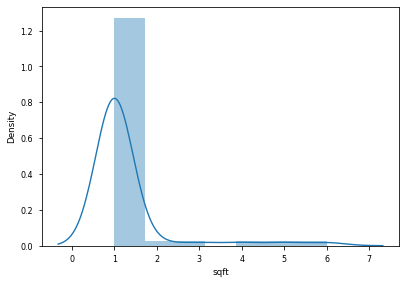

In [97]:
sns.distplot(data_d['sqft'])

In [98]:
data_d = data_d[(data_d['sqft'] < 10000)]

<AxesSubplot:xlabel='sqft', ylabel='Density'>

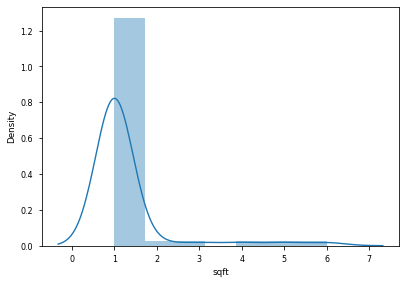

In [99]:

sns.distplot(data_d['sqft'])


# Ванны - приведение к численному виду.

In [100]:
data_d['baths'].unique()   

array(['1', 'Bathrooms: 3', '2 Baths', nan, '2 ba', '4 Baths', '3 Baths',
       '3.0', '2.5 Baths', '2.0', 'Bathrooms: 2', '4.0', '1,750',
       '8 Baths'], dtype=object)

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [101]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [102]:
data_d.baths = data_d.baths.apply(lambda x: main_extract_num(str(x)))

In [103]:
data_d['baths'].unique()   

array([1. , 3. , 2. , 4. , 2.5, 8. ])

In [104]:
data_d['baths'].isna().unique()   

array([False])

# Визуализация и обработка признака ванны (baths).

<AxesSubplot:xlabel='baths', ylabel='Density'>

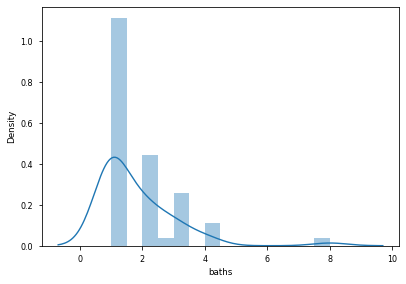

In [105]:
sns.distplot(data_d['baths'])

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [106]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [107]:
data_d['fireplace'].value_counts() 

Yes    2
yes    2
Name: fireplace, dtype: int64

In [108]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [109]:
data_d['fireplace'].unique()

array([0, 1])

In [110]:
data_d['fireplace'].isna().unique() 

array([False])

# Бассейн. Анализ.

In [111]:
data_d['private pool'].value_counts()

Series([], Name: private pool, dtype: int64)

In [112]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [113]:
data_d['propertyType'].value_counts(normalize=True)

lot/land                 0.36
multi-family             0.28
Single Family            0.14
single-family home       0.08
Mobile / Manufactured    0.04
mobile/manufactured      0.02
condo                    0.02
                         0.02
Multi Family             0.02
unknown                  0.02
Name: propertyType, dtype: float64

In [114]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [115]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [116]:
data_d['propertyType'].value_counts(normalize=True)

lot/land                 0.333333
multi-family             0.259259
sfh                      0.203704
nan                      0.074074
Mobile / Manufactured    0.037037
mobile/manufactured      0.018519
condo                    0.018519
                         0.018519
Multi Family             0.018519
unknown                  0.018519
Name: propertyType, dtype: float64

In [117]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [118]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [119]:
data_d['propertyType'].value_counts()

other    38
mlf      15
condo     1
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [120]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes

In [121]:
data_d['propertyType_cat'].value_counts()

2    38
1    15
0     1
Name: propertyType_cat, dtype: int64

In [122]:
data_d['propertyType'].isna().unique() 

array([False])

In [123]:
#plt.violinplot(data_d['propertyType'])

 # площадь

In [124]:
#data_d.beds = data_d.beds.apply(lambda x: 500 if (x==0 & data_d['sqft']!=0) else x)

# Город

In [125]:
data_d['city'].value_counts()

Chicago              15
Panama City           3
Miami                 3
Los Angeles           2
Panama City Beach     2
Nashville             2
Davie                 2
Jacksonville          1
Charlotte             1
Denver                1
Austin                1
Littleton             1
Kansas City           1
Wilton Manors         1
Waco                  1
Deltona               1
Spring Hill           1
Pompano Beach         1
Fort Lauderdale       1
Dallas                1
Johnson City          1
Pottstown             1
Bronx                 1
ST PETERSBURG         1
El Mirage             1
Sacramento            1
Old Hickory           1
Cincinnati            1
Palm Bay              1
El Paso               1
Clearwater            1
Knoxville             1
Name: city, dtype: int64

In [126]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes

In [127]:
data_d['city_cat'].value_counts()

3     15
23     3
19     3
18     2
24     2
20     2
7      2
13     1
2      1
9      1
0      1
17     1
15     1
31     1
30     1
8      1
29     1
25     1
12     1
6      1
14     1
26     1
1      1
27     1
10     1
28     1
21     1
4      1
22     1
11     1
5      1
16     1
Name: city_cat, dtype: int64

In [128]:
data_d['city_cat'].isna().unique()

array([False])

# Штат

In [129]:
data_d['state'].value_counts()

FL    18
IL    15
TN     5
TX     4
CA     3
CO     2
NC     2
PA     1
OH     1
AZ     1
NY     1
MO     1
Name: state, dtype: int64

In [130]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes

In [131]:
data_d['state_cat'].value_counts()

3     18
4     15
10     5
11     4
1      3
2      2
6      2
9      1
8      1
0      1
7      1
5      1
Name: state_cat, dtype: int64

In [132]:
data_d['state_cat'].isna().unique()

array([False])

# Улица

In [133]:
data_d['street'].head(50)

564                       524 SW 24th Ave
3763                          99 W 5th St
5881                 15777 Bolesta Rd #34
18537                 3138 W Wabansia Ave
25078                     3 Berryville St
29107                  4240 N Melvina Ave
32262                      241 High Rd NW
33732                      1310 W 71st Pl
40392                     5415 Tanner Ave
45447                       108 Shelby St
53926                       3001 26th Ave
78435     11201 N EL MIRAGE Rd Unit F108 
84881                6836 Bayou George Dr
91779                 3602 W Lexington St
103430               7777 46th Ave N #62 
119672                 7801 S Chappel Ave
132789                4212 S Campbell Ave
185717                    1901 NW 93rd St
187952                  2816 Brunswick Dr
190063                7125 N Lagoon Dr #L
196388                 4181 De Reimer Ave
197079                     2000 W 69th St
198333                    3941 Evadale Dr
198609                9816 Wilming

In [134]:
x_str=data_d['street']
y = data_d['target']

In [135]:
#plt.figure(figsize = (10,6))
#plt.scatter(x_str, y)
 
# добавим подписи
#plt.xlabel('Улица', fontsize = 15)
#plt.ylabel('Цена', fontsize = 15)
#plt.title('Зависимость цены от улицы', fontsize = 18)

 # Stories (надеюсь, это этажи)

In [136]:
data_d['stories'].value_counts()

1.0    12
2.0     4
0.0     2
2       1
Name: stories, dtype: int64

In [137]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [138]:
data_d['stories'].value_counts()

1.0    47
2.0     5
0.0     2
Name: stories, dtype: int64

In [139]:
data_d['stories'].isna().unique()

array([False])

 # Status

In [140]:
data_d['status'].value_counts()

for sale                     36
Active                        5
For sale                      3
foreclosure                   3
New construction              1
Pre-foreclosure / auction     1
Name: status, dtype: int64

In [141]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [142]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [143]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [144]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [145]:
data_d['status'].unique()

array(['nan', 'cnstr', 'for_sale', 'actv', 'frcls'], dtype=object)

In [146]:
data_d['status'].value_counts()

for_sale    39
nan          5
actv         5
frcls        4
cnstr        1
Name: status, dtype: int64

Приведение к численному виду.

In [147]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes

In [148]:
data_d['status'].isna().unique()

array([False])

# Индекс

In [149]:
data_d['zipcode'].value_counts()

32404    3
60621    2
60647    2
60636    2
37207    2
33324    2
80127    1
80216    1
60628    1
33184    1
33064    1
60637    1
34609    1
32738    1
33312    1
75236    1
28278    1
28540    1
78724    1
64151    1
33311    1
32407    1
76706    1
60618    1
60619    1
60631    1
37615    1
60624    1
33760    1
79928    1
60634    1
32907    1
45213    1
37138    1
95820    1
85335    1
33709    1
33186    1
60649    1
60632    1
33147    1
32408    1
10466    1
90031    1
90002    1
19464    1
37909    1
Name: zipcode, dtype: int64

In [150]:
data_d['zipcode'].unique()

array(['33312', '19464', '33760', '60647', '79928', '60634', '32907',
       '60636', '45213', '37138', '95820', '85335', '32404', '60624',
       '33709', '60649', '60632', '33147', '37207', '32408', '10466',
       '90031', '90002', '60631', '33186', '37615', '75236', '60619',
       '60621', '80216', '60628', '33184', '33064', '60637', '34609',
       '32738', '80127', '33324', '28278', '28540', '78724', '64151',
       '33311', '32407', '76706', '60618', '37909'], dtype=object)

In [151]:
data_d.zipcode = data_d.zipcode.apply(lambda x: 0 if (x.find('-')>-1) else x)

In [152]:
data_d.zipcode = data_d.zipcode.apply(lambda x: float(x))

In [153]:
data_d['zipcode'].value_counts()

32404.0    3
60621.0    2
60647.0    2
60636.0    2
37207.0    2
33324.0    2
80127.0    1
80216.0    1
60628.0    1
33184.0    1
33064.0    1
60637.0    1
34609.0    1
32738.0    1
33312.0    1
75236.0    1
28278.0    1
28540.0    1
78724.0    1
64151.0    1
33311.0    1
32407.0    1
76706.0    1
60618.0    1
60619.0    1
60631.0    1
37615.0    1
60624.0    1
33760.0    1
79928.0    1
60634.0    1
32907.0    1
45213.0    1
37138.0    1
95820.0    1
85335.0    1
33709.0    1
33186.0    1
60649.0    1
60632.0    1
33147.0    1
32408.0    1
10466.0    1
90031.0    1
90002.0    1
19464.0    1
37909.0    1
Name: zipcode, dtype: int64

In [154]:
data_d['zipcode'].isna().unique()

array([False])

In [155]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 564 to 366327
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   status            54 non-null     category
 1   private pool      0 non-null      object  
 2   propertyType      54 non-null     category
 3   street            54 non-null     object  
 4   baths             54 non-null     float64 
 5   homeFacts         54 non-null     object  
 6   fireplace         54 non-null     int64   
 7   city              54 non-null     category
 8   schools           54 non-null     object  
 9   sqft              54 non-null     float64 
 10  zipcode           54 non-null     float64 
 11  beds              54 non-null     int64   
 12  state             54 non-null     category
 13  stories           54 non-null     float64 
 14  mls-id            4 non-null      object  
 15  PrivatePool       1 non-null      object  
 16  MlsId             44 n

# Выбор предварительного датафрейма для модели

In [156]:
data_d_preliminary=data_d[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat','zipcode','target']]

In [157]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 564 to 366327
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   propertyType_cat  54 non-null     int8   
 1   baths             54 non-null     float64
 2   fireplace         54 non-null     int64  
 3   sqft              54 non-null     float64
 4   beds              54 non-null     int64  
 5   stories           54 non-null     float64
 6   status_cat        54 non-null     int8   
 7   city_cat          54 non-null     int8   
 8   state_cat         54 non-null     int8   
 9   zipcode           54 non-null     float64
 10  target            54 non-null     float64
dtypes: float64(5), int64(2), int8(4)
memory usage: 3.6 KB


In [158]:
#data_d_test=data_d[['sqft','target']]

In [159]:
data_d_preliminary

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode,target
564,2,1.0,0,1.0,1,1.0,4,12,3,33312.0,197717.0
3763,2,3.0,1,1.0,4,2.0,1,26,9,19464.0,217700.0
5881,2,2.0,0,6.0,2,1.0,2,5,3,33760.0,31900.0
18537,1,2.0,0,1.0,4,1.0,2,3,4,60647.0,480000.0
25078,2,1.0,0,1.0,1,1.0,2,11,11,79928.0,64000.0
29107,2,1.0,0,1.0,3,1.0,2,3,4,60634.0,245000.0
32262,2,2.0,0,1.0,3,1.0,2,22,3,32907.0,185900.0
33732,1,1.0,1,1.0,4,1.0,2,3,4,60636.0,144900.0
40392,2,1.0,0,1.0,1,2.0,2,4,8,45213.0,15000.0
45447,1,1.0,0,1.0,1,1.0,2,21,10,37138.0,159000.0


In [160]:
data_d_preliminary.isnull().sum()

propertyType_cat    0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
status_cat          0
city_cat            0
state_cat           0
zipcode             0
target              0
dtype: int64

# Визуализация

(11.5, -0.5)

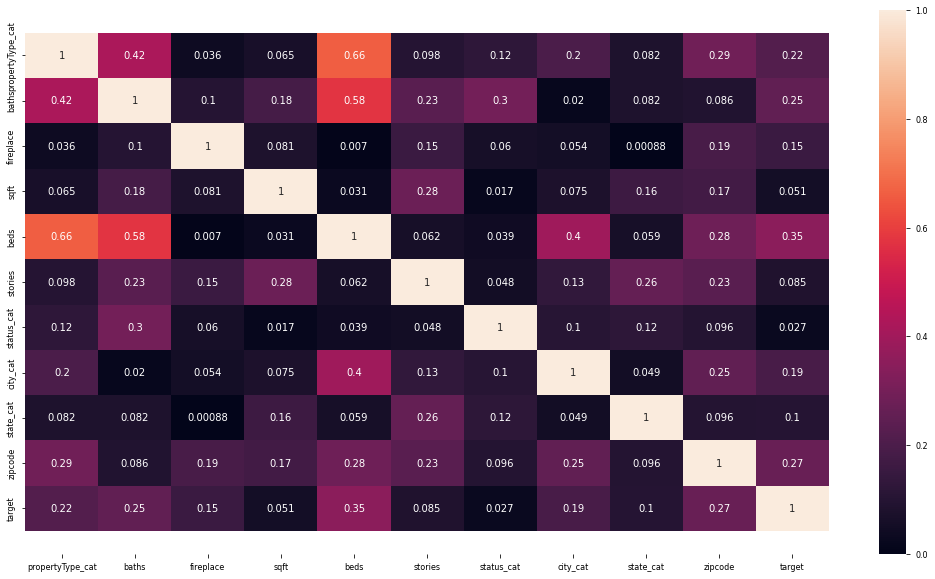

In [161]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [162]:
#  подготовка данных для графиков
x1 = data_d_preliminary['propertyType_cat']
x2 = data_d_preliminary['city_cat']
x3 = data_d_preliminary['baths']
x4 = data_d_preliminary['fireplace']
x5 = data_d_preliminary['sqft']
x6 = data_d_preliminary['beds']
x7 = data_d_preliminary['stories']
x8 = data_d_preliminary['state_cat']
x9 = data_d_preliminary['status_cat']
x10 = data_d_preliminary['zipcode']
#sdsfdf

y = data_d_preliminary['target']

Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

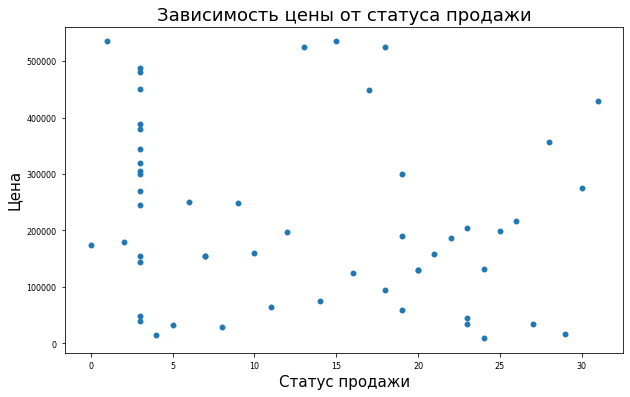

In [163]:
plt.figure(figsize = (10,6))
plt.scatter(x2, y)
 
# добавим подписи
plt.xlabel('Статус продажи', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от типа недвижимости')

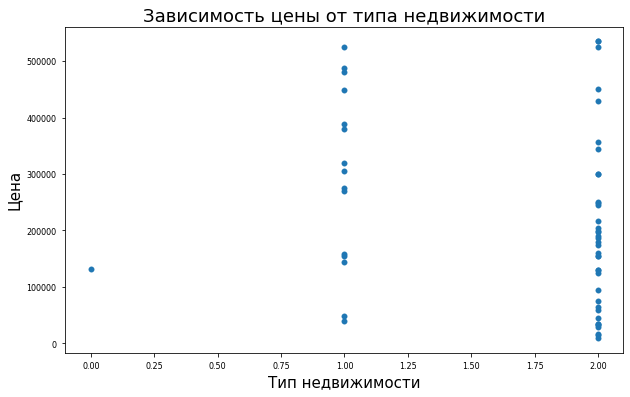

In [164]:
plt.figure(figsize = (10,6))
plt.scatter(x1, y)
 
# добавим подписи
plt.xlabel('Тип недвижимости', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от типа недвижимости', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

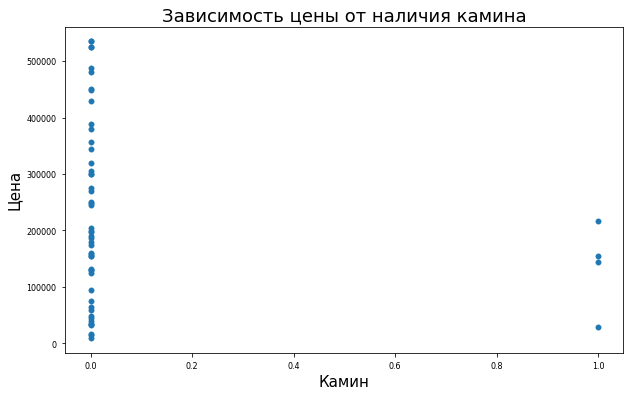

In [165]:
plt.figure(figsize = (10,6))
plt.scatter(x4, y)
 
# добавим подписи
plt.xlabel('Камин', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от площади')

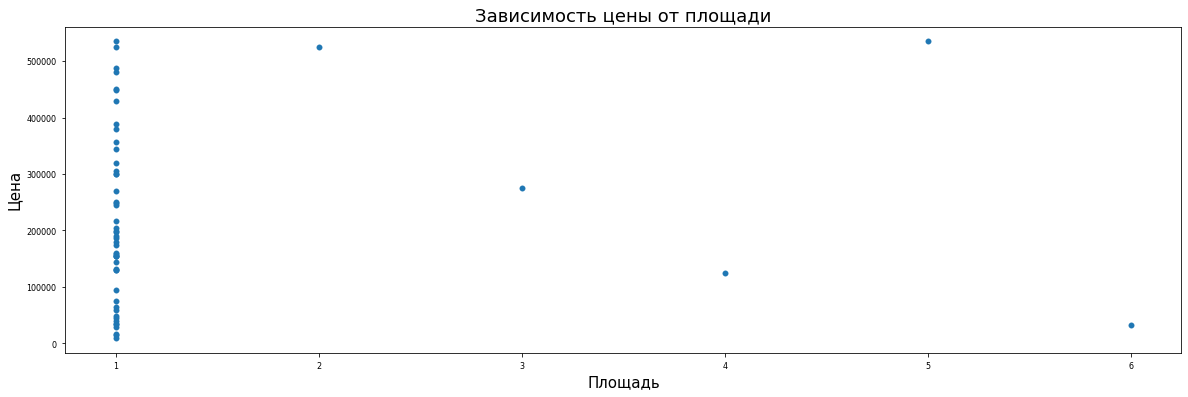

In [166]:
plt.figure(figsize = (20,6))
plt.scatter(x5, y)
 
# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

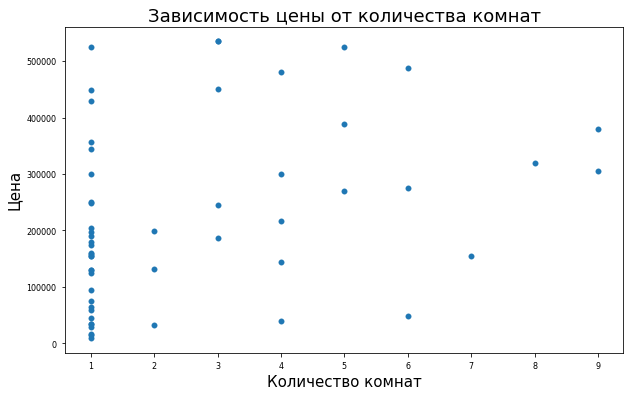

In [167]:
plt.figure(figsize = (10,6))
plt.scatter(x6, y)
 
# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от этажа')

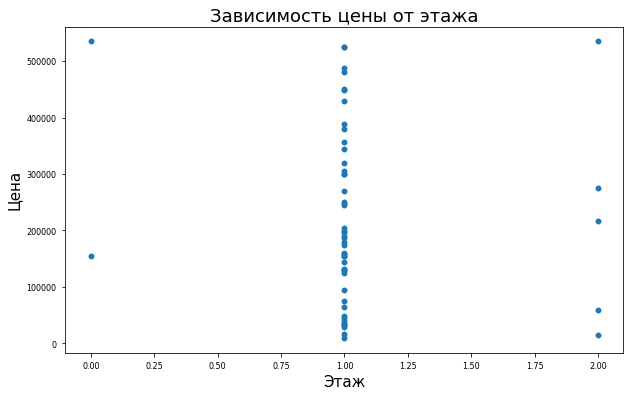

In [168]:
plt.figure(figsize = (10,6))
plt.scatter(x7, y)
 
# добавим подписи
plt.xlabel('Этаж', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от города')

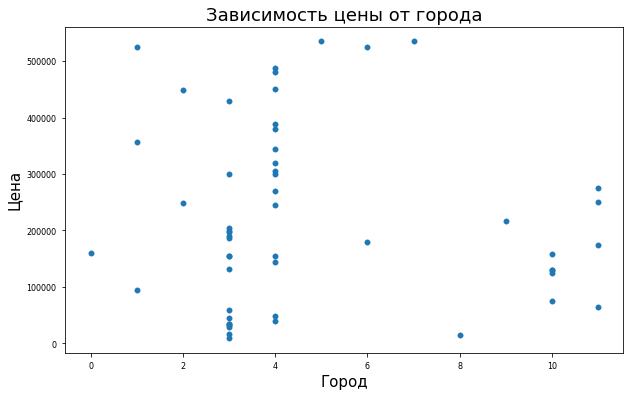

In [169]:
plt.figure(figsize = (10,6))
plt.scatter(x8, y)
 
# добавим подписи
plt.xlabel('Город', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

<AxesSubplot:xlabel='propertyType_cat'>

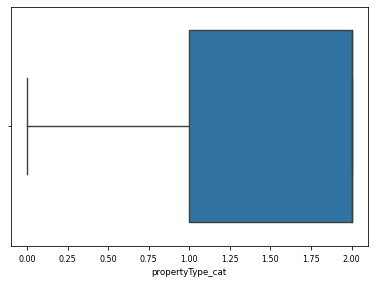

In [170]:
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='propertyType_cat'>

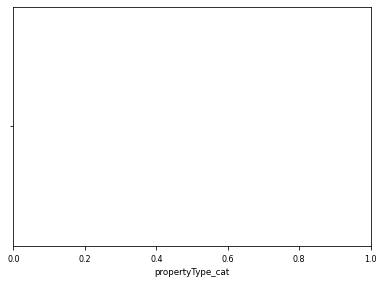

In [171]:
data_d_preliminary['propertyType_cat'] = data_d_preliminary[(data_d_preliminary['propertyType_cat'] > 4)]['propertyType_cat']
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='baths'>

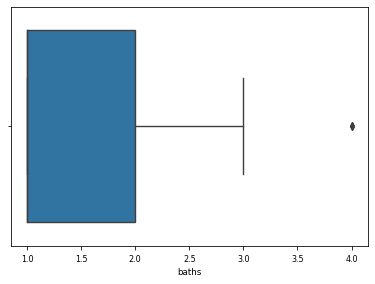

In [172]:
data_d_preliminary['baths'] = data_d_preliminary[(data_d_preliminary['baths'] < 8)]['baths']
sns.boxplot(data_d_preliminary['baths'])

<AxesSubplot:xlabel='fireplace'>

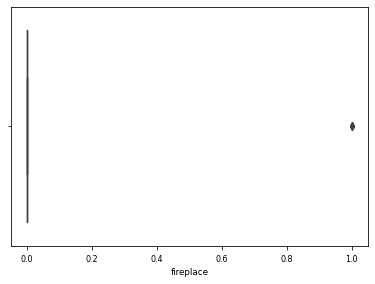

In [173]:
sns.boxplot(data_d_preliminary['fireplace'])

<AxesSubplot:xlabel='sqft'>

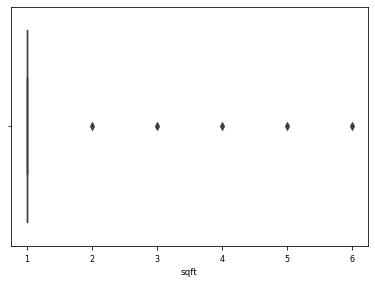

In [174]:
sns.boxplot(data_d_preliminary['sqft'])

<AxesSubplot:xlabel='beds'>

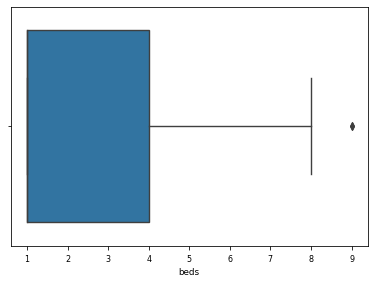

In [175]:
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='beds'>

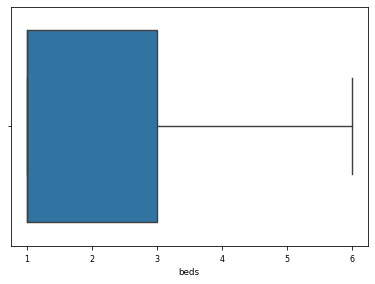

In [176]:
data_d_preliminary['beds'] = data_d_preliminary[(data_d_preliminary['beds'] < 7)]['beds']
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='stories'>

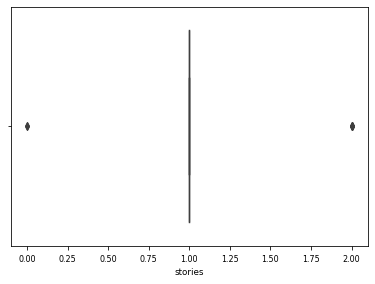

In [177]:
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='stories'>

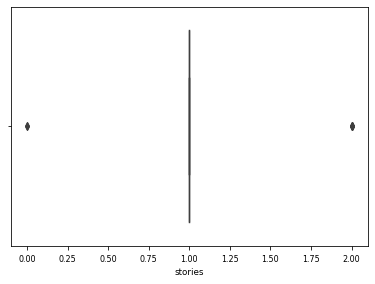

In [178]:
data_d_preliminary['stories'] = data_d_preliminary[(data_d_preliminary['stories'] < 5)]['stories']
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='state_cat'>

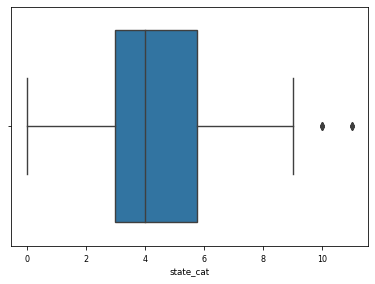

In [179]:
sns.boxplot(data_d_preliminary['state_cat'])

<AxesSubplot:xlabel='city_cat'>

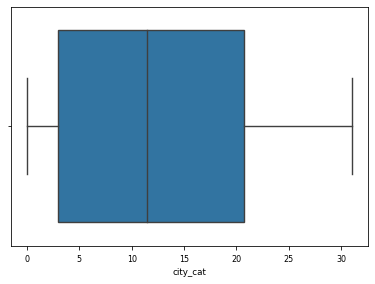

In [180]:
sns.boxplot(data_d_preliminary['city_cat'])

In [181]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [182]:
#data_d_preliminary.isna().sum()

In [183]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [184]:
#data_d_preliminary = data_d_preliminary.dropna()

In [185]:
#data_d_preliminary.isnull().sum()

(11.5, -0.5)

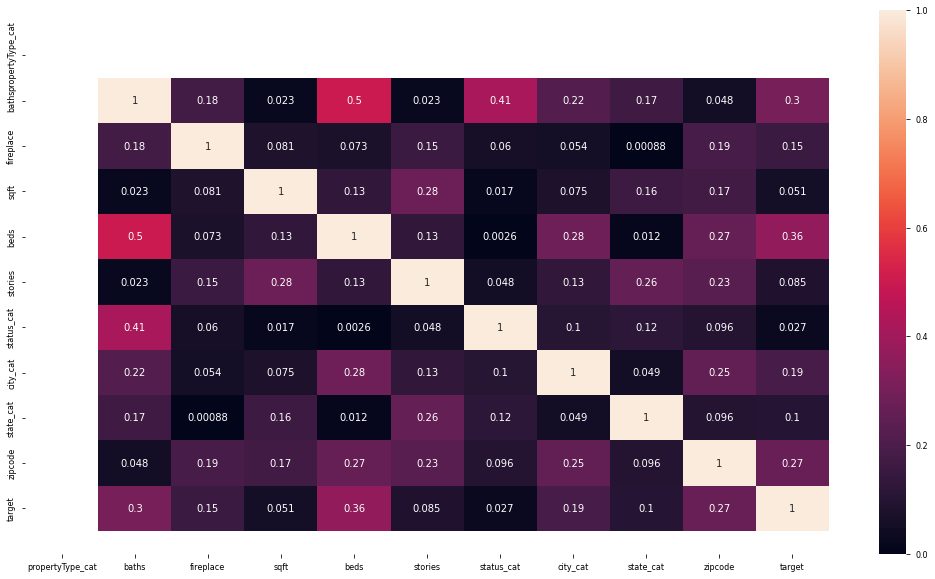

In [186]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Нормализация

In [187]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [188]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [189]:
# data_d_preliminaty_n

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode,target
0,NaN,0.000000,0.0,0.0,0.0,0.5,1.00,0.387097,0.272727,0.267662,0.357801
1,NaN,0.666667,1.0,0.0,0.6,1.0,0.25,0.838710,0.818182,0.105420,0.395849
2,NaN,0.333333,0.0,1.0,0.2,0.5,0.50,0.161290,0.272727,0.272910,0.042079
3,NaN,0.333333,0.0,0.0,0.6,0.5,0.50,0.096774,0.363636,0.587916,0.895278
4,NaN,0.000000,0.0,0.0,0.0,0.5,0.50,0.354839,1.000000,0.813811,0.103199
5,NaN,0.000000,0.0,0.0,0.4,0.5,0.50,0.096774,0.363636,0.587764,0.447829
6,NaN,0.333333,0.0,0.0,0.4,0.5,0.50,0.709677,0.272727,0.262917,0.335301
7,NaN,0.000000,1.0,0.0,0.6,0.5,0.50,0.096774,0.363636,0.587787,0.257235
8,NaN,0.000000,0.0,0.0,0.0,1.0,0.50,0.129032,0.727273,0.407093,0.009901
9,NaN,0.000000,0.0,0.0,0.0,0.5,0.50,0.677419,0.909091,0.312487,0.284082


(11.5, -0.5)

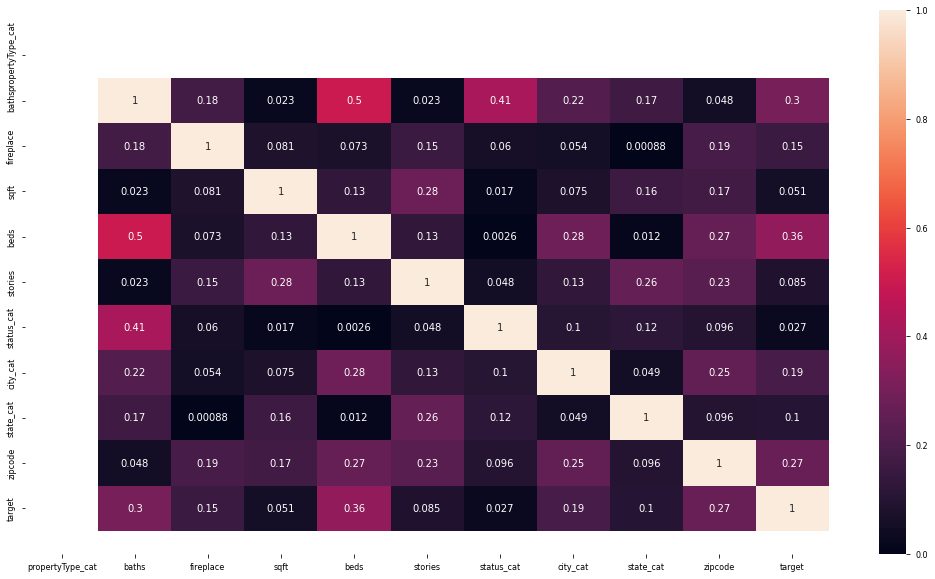

In [190]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [191]:
data_d_preliminary

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode,target
564,NaN,1.0,0,1.0,1.0,1.0,4,12,3,33312.0,197717.0
3763,NaN,3.0,1,1.0,4.0,2.0,1,26,9,19464.0,217700.0
5881,NaN,2.0,0,6.0,2.0,1.0,2,5,3,33760.0,31900.0
18537,NaN,2.0,0,1.0,4.0,1.0,2,3,4,60647.0,480000.0
25078,NaN,1.0,0,1.0,1.0,1.0,2,11,11,79928.0,64000.0
29107,NaN,1.0,0,1.0,3.0,1.0,2,3,4,60634.0,245000.0
32262,NaN,2.0,0,1.0,3.0,1.0,2,22,3,32907.0,185900.0
33732,NaN,1.0,1,1.0,4.0,1.0,2,3,4,60636.0,144900.0
40392,NaN,1.0,0,1.0,1.0,2.0,2,4,8,45213.0,15000.0
45447,NaN,1.0,0,1.0,1.0,1.0,2,21,10,37138.0,159000.0


In [192]:
# data_d_preliminary=data_d_preliminary.dropna()

In [193]:
X=data_d_preliminary[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat','zipcode']]

In [194]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   propertyType_cat  0 non-null      float64
 1   baths             0 non-null      float64
 2   fireplace         0 non-null      int64  
 3   sqft              0 non-null      float64
 4   beds              0 non-null      float64
 5   stories           0 non-null      float64
 6   status_cat        0 non-null      int8   
 7   city_cat          0 non-null      int8   
 8   state_cat         0 non-null      int8   
 9   zipcode           0 non-null      float64
dtypes: float64(6), int64(1), int8(3)
memory usage: 0.0 bytes


In [195]:
X

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,zipcode


In [196]:
#X_tes = data_d_test[['sqft']]
#y_tes = data_d_test[['target']]

In [197]:
#X_tes

In [198]:

y = data_d_preliminary[['target']]
y

#X1 = data_d_preliminary[['sity_state_cat','baths','beds']]

,target


In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

ValueError: With n_samples=0, test_size=None and train_size=0.67, the resulting train set will be empty. Adjust any of the aforementioned parameters.

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


In [ ]:
print(np.array(y_test.index.values))

In [ ]:
print(mape(np.array(y_test.index.values), predict_extra_tree))

In [ ]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

In [ ]:
predict_catboost = catboost.predict(X_test)
predict_catboost_exp=np.exp(predict_catboost)

predict_catboost_exp

In [ ]:
print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

In [ ]:
predict_catboost 

In [ ]:
y_test1=y_test.index.values

In [ ]:
y_test1

In [ ]:
print_regression_metrics(y_test1, predict_catboost)

In [ ]:
print(f"MAPE: {(mape_log(y_test1, predict_catboost))*100:0.2f}%")

In [ ]:
model = LinearRegression()


In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
y_pred_exp=np.exp(y_pred)
y_pred_exp

In [ ]:
from sklearn import metrics

In [ ]:
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_exp)))


In [ ]:
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

In [ ]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()